# Fine-Tuning CNNs

Here we developed some CNNs and trained them. Afterwards we predicted the test set and exported the results.


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from shutil import copyfile
from sklearn.model_selection import train_test_split
from IPython.display import SVG,display
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from keras.applications import VGG16
from keras.applications.vgg16 import decode_predictions
from keras.preprocessing.image import load_img
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

In [10]:
# create a subfolder for each class to provide ground-truth to the CNN when training
def createDirectoryEnvironment(train_data, train_targets, val_data, val_targets, path):
    trainpath = path + 'train/'
    valpath = path + 'validation/'
    if(os.listdir() == 2):
        return trainpath,valpath
    if(not os.path.exists(trainpath)):
        os.mkdir(trainpath)
    if(not os.path.exists(valpath)):
        os.mkdir(valpath)
        
    classes = train_targets.columns.append(val_targets.columns).drop_duplicates()  
    for c in classes:
        train_class = trainpath + c + '/'
        val_class = valpath + c + '/'
        if(not os.path.exists(train_class)):
            os.mkdir(train_class)
        if(not os.path.exists(val_class)):
            os.mkdir(val_class)
            
    for f in train_data.index.values:
        copyfile(path + '../LabeledData/' + f, 
                 trainpath + train_targets.loc[f].idxmax(axis = 1) + '/' + f)
    for f in val_data.index.values:
        copyfile(path + '../LabeledData/' + f, 
                 valpath + val_targets.loc[f].idxmax(axis = 1) + '/' + f)
    
    return trainpath, valpath            

In [20]:
# creates the directory for test
def createTestDirectory(test_data, folder_path):
    test_path = folder_path + 'test/unknown2/'
    if(os.path.exists(test_path)):
        return '/'.join(test_path.split('/')[:-2])
    else:
        os.mkdir(test_path)
    for f in test_data.index:
        copyfile(folder_path + f[:f.find('frame')-1] + '/' + f, test_path + f)
    return '/'.join(test_path.split('/')[:-2])

# Data Pre-Processing

In [11]:

folder_path = "/media/newdrive/20180501/ProcessedImages/"
data = pd.read_csv(folder_path + "sampled_data.csv")

filenames = data['filename']
targets = data['level3'].replace(['A3.1', 'A4.1'], 'A3.1-A4.1').replace(['A3.7', 'A4.7'], 'A3.7-A4.7')

# one-hot encoding
targets_ohe = pd.get_dummies(targets)

# dealing with NaNs
data = data.drop(['roll', 'pitch', 'level1', 'level2', 'level3', 'level4', 
                  'level5', 'level6', 'AphiaID', 'EunisName', 'EunisCode', 
                  'date', 'timestamp', 'species'],
                 axis = 1)

X = data.groupby('filename').max()
Y = pd.concat([filenames,targets_ohe], axis = 1).groupby('filename').max()


# tts
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size = 0.3, random_state=47)

images_path = '/media/newdrive/20180501/ProcessedImages/SampledData/'
#train_dir, val_dir = createDirectoryEnvironment(train_X, train_Y, test_X, test_Y, images_path) # uncomment to create the directory

# Transfer Learning and Fine-Tuning CNNs (DenseNet, ResNet, VGG16, Inception v3 and v4)

In [ ]:
from keras.applications.densenet import DenseNet201
dense = DenseNet201(weights='imagenet')
x = Dense(5, activation='softmax', name='predictions')(dense.layers[-2].output)
dense_classifier = Model(input=dense.input, output=x)

In [ ]:
vgg16_ft = VGG16(weights = 'imagenet')
x = Dense(7, activation='softmax', name='predictions')(vgg16_ft.layers[-2].output)
eunis_classifier = Model(input=vgg16_ft.input, output=x)

eunis_classifier.summary()

In [72]:
#The weights should correspond to the same model shape. Uncomment the next line if you want to load already computed weights. 
#eunis_classifier.load_weights('/home/diegues/git/AutomaticHabitatMapping/src/weights/eunis_photo_classifier.h5') 


# Image Data Generators to apply Data Augmentation and read from directories 

In [5]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
train_batchsize = 1
val_batchsize = 1
 
train_generator = train_datagen.flow_from_directory(
        "/home/diegues/Desktop/ProcessedImages/SampledData/train/",
        target_size=(224, 224),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        "/home/diegues/Desktop/ProcessedImages/SampledData/validation/",
        target_size=(224, 224),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 457 images belonging to 5 classes.
Found 197 images belonging to 5 classes.


# CNN Compilation

In [6]:
sgd_optimizer = SGD(lr=0.001)
dense_classifier.compile(loss='categorical_crossentropy',
                        optimizer=sgd_optimizer, 
                        metrics=['acc'])
tensorboard = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
best_checkpoint = ModelCheckpoint('./weights/dense.h5', monitor='val_acc', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_acc', patience=20, verbose=1)
reducer = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=5, verbose=1, min_lr=1e-7)

In [14]:
# Plots the CNN and saves it to a file
plot_model(incResNet_classifier,
           to_file='incResNet.png',
           show_shapes=True,
           show_layer_names=True,
           rankdir='TB'
)

# CNN Training and Analysis

In [7]:
history = dense_classifier.fit_generator(train_generator, 
                                         steps_per_epoch=len(train_X)//train_batchsize,
                                         epochs=500,
                                         validation_data=validation_generator,
                                         validation_steps = len(test_X)//val_batchsize,
                                         callbacks=[tensorboard, best_checkpoint, earlystop, reducer]
                                        )

Epoch 1/500
457/457 [==============================] - 116s 254ms/step - loss: 1.5119 - acc: 0.2670 - val_loss: 1.8500 - val_acc: 0.1523

Epoch 00001: val_acc improved from -inf to 0.15228, saving model to ./weights/dense.h5
Epoch 2/500
457/457 [==============================] - 90s 197ms/step - loss: 1.4942 - acc: 0.2670 - val_loss: 1.8863 - val_acc: 0.1421

Epoch 00002: val_acc did not improve from 0.15228
Epoch 3/500
457/457 [==============================] - 89s 195ms/step - loss: 1.4944 - acc: 0.2670 - val_loss: 1.8810 - val_acc: 0.1624

Epoch 00003: val_acc improved from 0.15228 to 0.16244, saving model to ./weights/dense.h5
Epoch 4/500
457/457 [==============================] - 89s 195ms/step - loss: 1.4968 - acc: 0.2626 - val_loss: 1.8886 - val_acc: 0.1472

Epoch 00004: val_acc did not improve from 0.16244
Epoch 5/500
457/457 [==============================] - 90s 196ms/step - loss: 1.4993 - acc: 0.2735 - val_loss: 1.8441 - val_acc: 0.1421

Epoch 00005: val_acc did not improve 

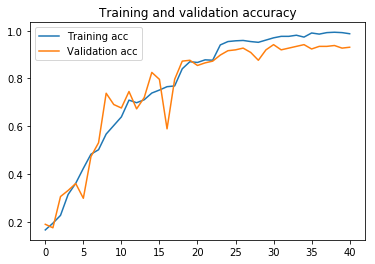

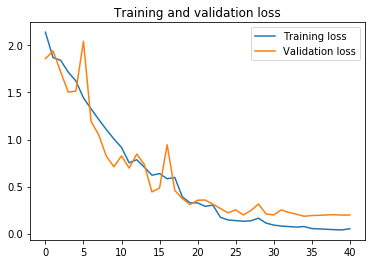

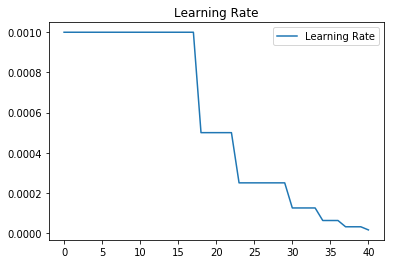

In [76]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
lr = history.history['lr']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('train_val_acc.jpg')

plt.figure()
 
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('train_val_loss.jpg')
plt.show()

plt.figure()
 
plt.plot(epochs, lr, label='Learning Rate')
plt.title('Learning Rate')
plt.legend()
plt.savefig('learning_rate.jpg')
plt.show()

275/275 [==============================] - 7s 25ms/step
No of errors = 19/275


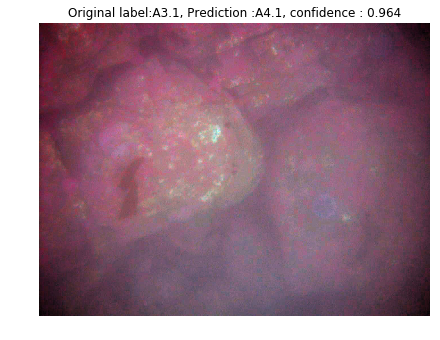

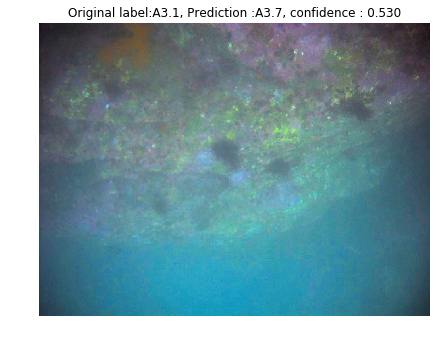

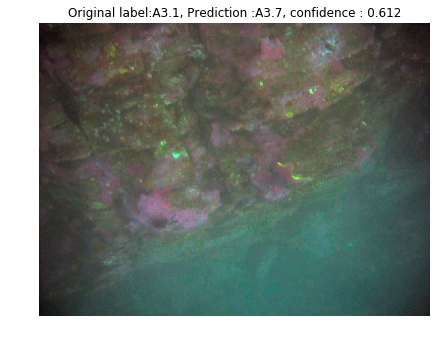

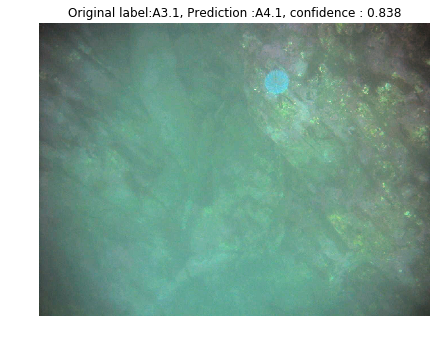

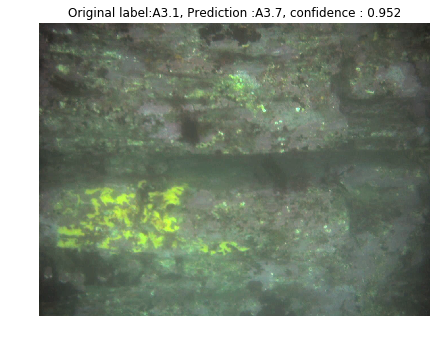

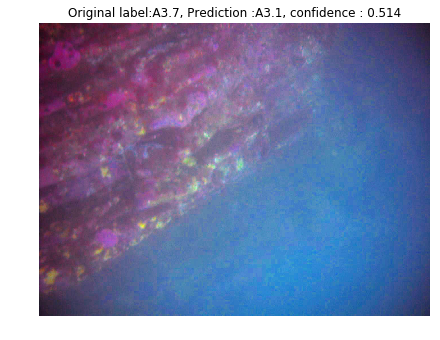

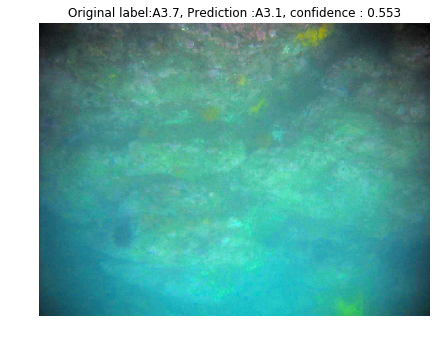

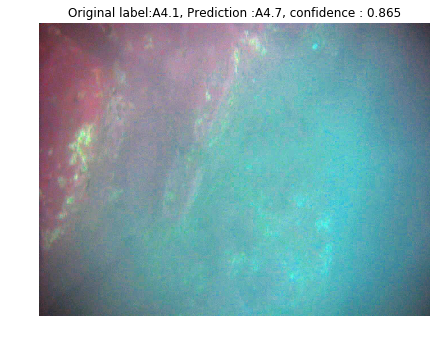

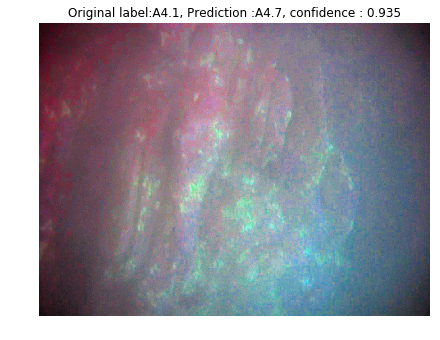

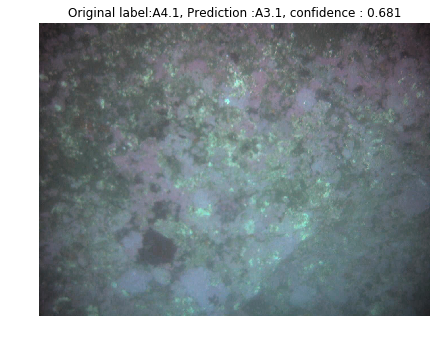

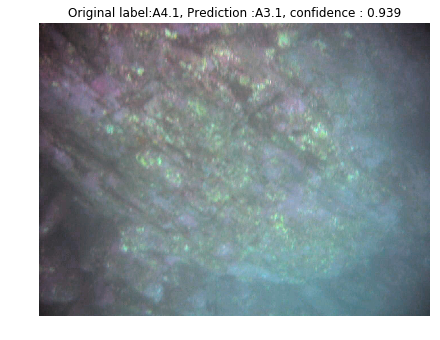

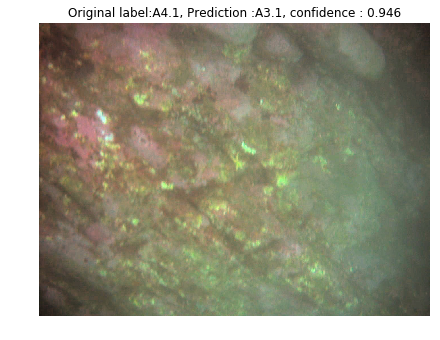

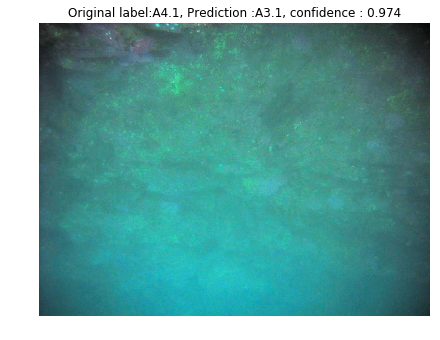

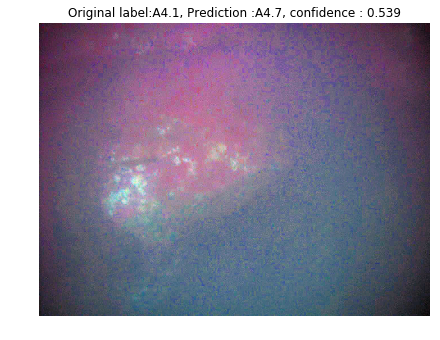

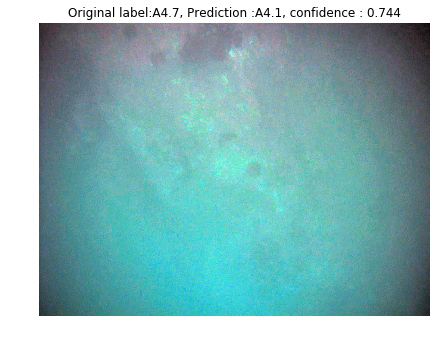

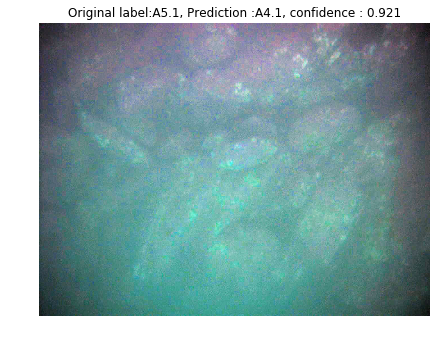

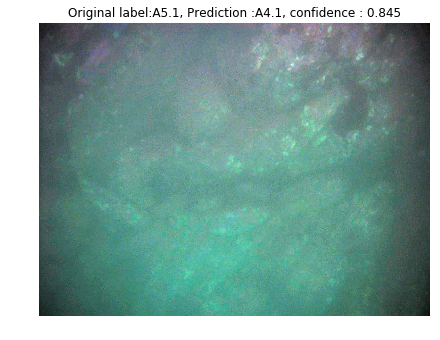

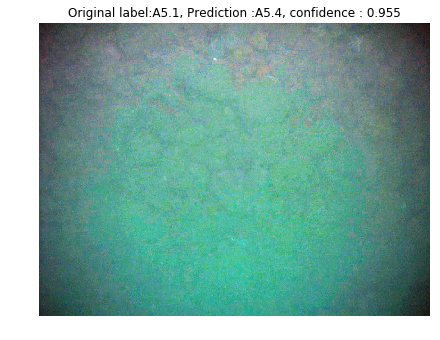

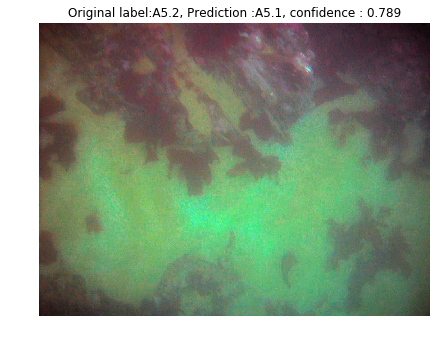

In [23]:
fnames = validation_generator.filenames
 
# Get the ground truth from generator
ground_truth = validation_generator.classes
 
# Get the label to class mapping from the generator
label2index = validation_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
predictions = eunis_classifier.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)
 
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))
 
# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
     
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
     
    original = load_img('{}/{}'.format(val_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

In [192]:
folder_path = '/home/diegues/Desktop/ProcessedImages/'
test_data = pd.read_csv(folder_path + 'unlabeled_data.csv')
test_dir = createTestDirectory(test_data, folder_path)


In [17]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=1,
        class_mode=None,
        shuffle=False)

Found 4702 images belonging to 1 classes.


In [28]:
cnn_preds = eunis_classifier.predict_generator(test_generator, 
                          steps=len(test_data), verbose=1)

4702/4702 [==============================] - 119s 25ms/step


In [29]:
cnn_preds = pd.DataFrame(cnn_preds).set_index(test_data.filename)
cnn_preds.columns = test_Y.columns
cnn_preds['level3'] = cnn_preds.idxmax(axis=1)
cnn_preds.head()

A3.1      A3.7      A4.1      A4.7  \
filename                                                                    
132143_forcadinho-np3_frame7.jpg   0.000240  0.000278  0.111026  0.888259   
132143_forcadinho-np3_frame8.jpg   0.000003  0.000005  0.011117  0.988815   
132143_forcadinho-np3_frame9.jpg   0.000397  0.000190  0.548168  0.451131   
132143_forcadinho-np3_frame10.jpg  0.000665  0.000598  0.505403  0.186246   
132143_forcadinho-np3_frame11.jpg  0.000206  0.000234  0.834498  0.149035   

                                       A5.1      A5.2      A5.4 level3  
filename                                                                
132143_forcadinho-np3_frame7.jpg   0.000053  0.000132  0.000012   A4.7  
132143_forcadinho-np3_frame8.jpg   0.000007  0.000051  0.000002   A4.7  
132143_forcadinho-np3_frame9.jpg   0.000084  0.000020  0.000011   A4.1  
132143_forcadinho-np3_frame10.jpg  0.097297  0.177089  0.032701   A4.1  
132143_forcadinho-np3_frame11.jpg  0.002760  0.012107  0.001160   A4.1

Text(0.5,1,'Fine-Tuning VGG16')

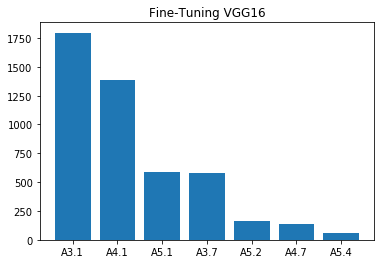

In [16]:
plt.bar(cnn_preds.level3.value_counts().index.tolist(), cnn_preds.level3.value_counts())
plt.title('Fine-Tuning VGG16')

In [193]:
new_test_data = test_data
new_test_data = new_test_data.set_index('filename')
new_test_data['EunisCode'] = pd.DataFrame(cnn_preds.level3)

In [194]:
new_test_data['altitude'] = np.zeros(len(new_test_data))
new_test_data

timestamp  latitude  longitude  roll  \
filename                                                                     
132143_forcadinho-np3_frame7.jpg   1.525181e+09  41.53101   -8.80974 -5.62   
132143_forcadinho-np3_frame8.jpg   1.525181e+09  41.53101   -8.80975 -3.79   
132143_forcadinho-np3_frame9.jpg   1.525181e+09  41.53101   -8.80975 -3.79   
132143_forcadinho-np3_frame10.jpg  1.525181e+09  41.53101   -8.80975 -3.79   
132143_forcadinho-np3_frame11.jpg  1.525181e+09  41.53101   -8.80975 -3.79   
132143_forcadinho-np3_frame12.jpg  1.525181e+09  41.53101   -8.80975 -3.79   
132143_forcadinho-np3_frame13.jpg  1.525181e+09  41.53101   -8.80975 -3.79   
132143_forcadinho-np3_frame15.jpg  1.525181e+09  41.53101   -8.80975 -2.65   
132143_forcadinho-np3_frame16.jpg  1.525181e+09  41.53101   -8.80975 -2.65   
132143_forcadinho-np3_frame17.jpg  1.525181e+09  41.53101   -8.80975 -2.65   
132143_forcadinho-np3_frame19.jpg  1.525181e+09  41.53101   -8.80975 -2.65   
132143_forcadinho-np3_frame20.jpg  1.525181e+09  41.53101   -8.80975 -2.65   
132143_forcadinho-np3_frame21.jpg  1.525181e+09  41.53101   -8.80975 -2.65   
132143_forcadinho-np3_frame22.jpg  1.525181e+09  41.53100   -8.80975 -1.50   
132143_forcadinho-np3_frame24.jpg  1.525181e+09  41.53100   -8.80975 -1.50   
132143_forcadinho-np3_frame25.jpg  1.525181e+09  41.53100   -8.80975 -1.50   
132143_forcadinho-np3_frame27.jpg  1.525181e+09  41.53100   -8.80975 -1.50   
132143_forcadinho-np3_frame28.jpg  1.525181e+09  41.53100   -8.80975 -1.50   
132143_forcadinho-np3_frame29.jpg  1.525181e+09  41.53100   -8.80976 -1.30   
132143_forcadinho-np3_frame30.jpg  1.525181e+09  41.53100   -8.80976 -1.30   
132143_forcadinho-np3_frame31.jpg  1.525181e+09  41.53100   -8.80976 -1.30   
132143_forcadinho-np3_frame33.jpg  1.525181e+09  41.53100   -8.80976 -1.30   
132143_forcadinho-np3_frame34.jpg  1.525181e+09  41.53100   -8.80976 -1.30   
132143_forcadinho-np3_frame35.jpg  1.525181e+09  41.53100   -8.80976 -1.30   
132143_forcadinho-np3_frame36.jpg  1.525181e+09  41.53100   -8.80976 -0.82   
132143_forcadinho-np3_frame37.jpg  1.525181e+09  41.53100   -8.80976 -0.82   
132143_forcadinho-np3_frame60.jpg  1.525181e+09  41.53096   -8.81002 -6.53   
132143_forcadinho-np3_frame61.jpg  1.525181e+09  41.53096   -8.81002 -6.53   
132143_forcadinho-np3_frame62.jpg  1.525181e+09  41.53096   -8.81002 -6.53   
132143_forcadinho-np3_frame63.jpg  1.525181e+09  41.53096   -8.81002 -6.53   
...                                         ...       ...        ...   ...   
113610_cam_survey_1_frame2941.jpg  1.525176e+09  41.53304   -8.80644 -1.83   
113610_cam_survey_1_frame2942.jpg  1.525176e+09  41.53304   -8.80644 -1.83   
113610_cam_survey_1_frame2943.jpg  1.525176e+09  41.53304   -8.80644  0.53   
113610_cam_survey_1_frame2944.jpg  1.525176e+09  41.53304   -8.80644  0.53   
113610_cam_survey_1_frame2946.jpg  1.525176e+09  41.53304   -8.80644  0.53   
113610_cam_survey_1_frame2947.jpg  1.525176e+09  41.53304   -8.80644  0.53   
113610_cam_survey_1_frame2948.jpg  1.525176e+09  41.53304   -8.80644  0.53   
113610_cam_survey_1_frame2949.jpg  1.525176e+09  41.53304   -8.80644  0.53   
113610_cam_survey_1_frame2950.jpg  1.525176e+09  41.53304   -8.80644  1.08   
113610_cam_survey_1_frame2951.jpg  1.525176e+09  41.53304   -8.80644  1.08   
113610_cam_survey_1_frame2952.jpg  1.525176e+09  41.53304   -8.80644  1.08   
113610_cam_survey_1_frame2953.jpg  1.525176e+09  41.53304   -8.80644  1.08   
113610_cam_survey_1_frame2954.jpg  1.525176e+09  41.53304   -8.80644  1.08   
113610_cam_survey_1_frame2955.jpg  1.525176e+09  41.53304   -8.80644  1.08   
113610_cam_survey_1_frame2956.jpg  1.525176e+09  41.53304   -8.80644  1.08   
113610_cam_survey_1_frame2957.jpg  1.525176e+09  41.53304   -8.80644  1.08   
113610_cam_survey_1_frame2958.jpg  1.525176e+09  41.53304   -8.80644  1.08   
113610_cam_survey_1_frame2959.jpg  1.525176e+09  41.53304   -8.80644  1.08   
113610_cam_survey_1_frame2961.jpg  1.525176e+09  41.53304   

In [19]:
folder = new_test_data[['timestamp','latitude','longitude', 'roll', 'pitch', 'altitude', 'depth', 'entropy', 'date']]
folder.to_csv(test_dir + '/unknown/unknown.csv')

In [20]:
folder_target = new_test_data[['date','longitude','latitude', 'depth','EunisCode', 'EunisName', 'level1', 'level2', 'level3', 'level4', 'level5', 'level6', 'species', 'AphiaID']]
folder_target.to_csv(test_dir + '/unknown/unknown-targets.csv')

In [73]:
test_targets = pd.read_csv('/home/diegues/Downloads/test-targets.csv', index_col=0)
test_targets.head()

date  longitude  latitude  depth EunisCode  \
filename                                                                       
105317_cam-np3_frame1118.jpg  01/05/18   -8.81473  41.53074  14.39      A3.1   
105317_cam-np3_frame1129.jpg  01/05/18   -8.81482  41.53077  14.06      A3.1   
105317_cam-np3_frame1136.jpg  01/05/18   -8.81011  41.53095  14.09      A4.1   
105317_cam-np3_frame1342.jpg  01/05/18   -8.81545  41.53152  17.72      A3.7   
105317_cam-np3_frame1343.jpg  01/05/18   -8.81545  41.53152  17.72      A3.7   

                                                                      EunisName  \
filename                                                                          
105317_cam-np3_frame1118.jpg                                                NaN   
105317_cam-np3_frame1129.jpg                                                NaN   
105317_cam-np3_frame1136.jpg  Atlantic and Mediterranean high energy circali...   
105317_cam-np3_frame1342.jpg                                                NaN   
105317_cam-np3_frame1343.jpg                                                NaN   

                             level1 level2 level3 level4  level5  level6  \
filename                                                                   
105317_cam-np3_frame1118.jpg      A     A3   A3.1    NaN     NaN     NaN   
105317_cam-np3_frame1129.jpg      A     A3   A3.1    NaN     NaN     NaN   
105317_cam-np3_frame1136.jpg      A     A4   A4.1    NaN     NaN     NaN   
105317_cam-np3_frame1342.jpg      A     A3   A3.7    NaN     NaN     NaN   
105317_cam-np3_frame1343.jpg      A     A3   A3.7    NaN     NaN     NaN   

                                         species   AphiaID  
filename                                                    
105317_cam-np3_frame1118.jpg                 NaN       NaN  
105317_cam-np3_frame1129.jpg                 NaN       NaN  
105317_cam-np3_frame1136.jpg  Echinus esculentus  124287.0  
105317_cam-np3_frame1342.jpg                 NaN       NaN  
105317_cam-np3_frame1343.jpg                 NaN       NaN

In [3]:
test_targets = test_targets['level3']
test_targets

filename
105317_cam-np3_frame1118.jpg          A3.1
105317_cam-np3_frame1129.jpg          A3.1
105317_cam-np3_frame1136.jpg          A4.1
105317_cam-np3_frame1342.jpg          A3.7
105317_cam-np3_frame1343.jpg          A3.7
105317_cam-np3_frame1344.jpg          A3.7
105317_cam-np3_frame1345.jpg          A3.7
105317_cam-np3_frame1346.jpg          A4.1
105317_cam-np3_frame1347.jpg          A3.7
105317_cam-np3_frame1348.jpg          A3.7
105317_cam-np3_frame1351.jpg          A3.7
105317_cam-np3_frame1352.jpg          A3.7
105317_cam-np3_frame1358.jpg          A3.1
105317_cam-np3_frame1360.jpg          A3.1
105317_cam-np3_frame1361.jpg          A3.1
105317_cam-np3_frame1362.jpg          A3.1
105317_cam-np3_frame1364.jpg          A3.7
105317_cam-np3_frame1365.jpg          A4.1
105317_cam-np3_frame1369.jpg          A3.7
105317_cam-np3_frame1376.jpg          A3.7
105317_cam-np3_frame1383.jpg          A3.7
105317_cam-np3_frame1384.jpg          A3.7
105317_cam-np3_frame1386.jpg          A3.7
10

# Model with Dropout


In [13]:
vgg = VGG16(weights='imagenet')
fc1 = vgg.layers[-3]
fc2 = vgg.layers[-2]
predictions = Dense(5, activation='softmax', name='predictions')


dropout1 = Dropout(0.5)
dropout2 = Dropout(0.5)

x = dropout1(fc1.output)
x = fc2(x)
x = dropout2(x)
predictors = predictions(x)

eunis_classifier_w_dropout = Model(input=vgg.input, output=predictors)
eunis_classifier_w_dropout.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/home/diegues/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  from ipykernel import kernelapp as app


In [45]:
eunis_classifier_w_dropout.load_weights('weights/justflips.h5')

In [14]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=360,
      vertical_flip=True,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
train_batchsize = 1
val_batchsize = 1
 
train_generator = train_datagen.flow_from_directory(
        '/media/newdrive/20180501/ProcessedImages/SampledData/train/',
        target_size=(224, 224),
        batch_size=train_batchsize,
        class_mode='categorical', 
        save_to_dir='/media/newdrive/aug/', save_prefix='aug')
 
validation_generator = validation_datagen.flow_from_directory(
        '/media/newdrive/20180501/ProcessedImages/SampledData/validation/',
        target_size=(224, 224),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 457 images belonging to 5 classes.
Found 197 images belonging to 5 classes.


In [65]:
eunis_classifier_w_dropout.load_weights('weights/unenhanced_images.h5')

In [66]:
sgd_optimizer = SGD(lr=0.001)
eunis_classifier_w_dropout.compile(loss='categorical_crossentropy',
                        optimizer=sgd_optimizer, 
                        metrics=['acc'])
tensorboard = TensorBoard(log_dir='./Graph/unenhanced_images', histogram_freq=0, write_graph=True, write_images=True)
best_checkpoint = ModelCheckpoint('./weights/unenhanced_images.h5', monitor='val_acc', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_acc', patience=10, verbose=1)
reducer = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=3, verbose=1, min_lr=1e-7)

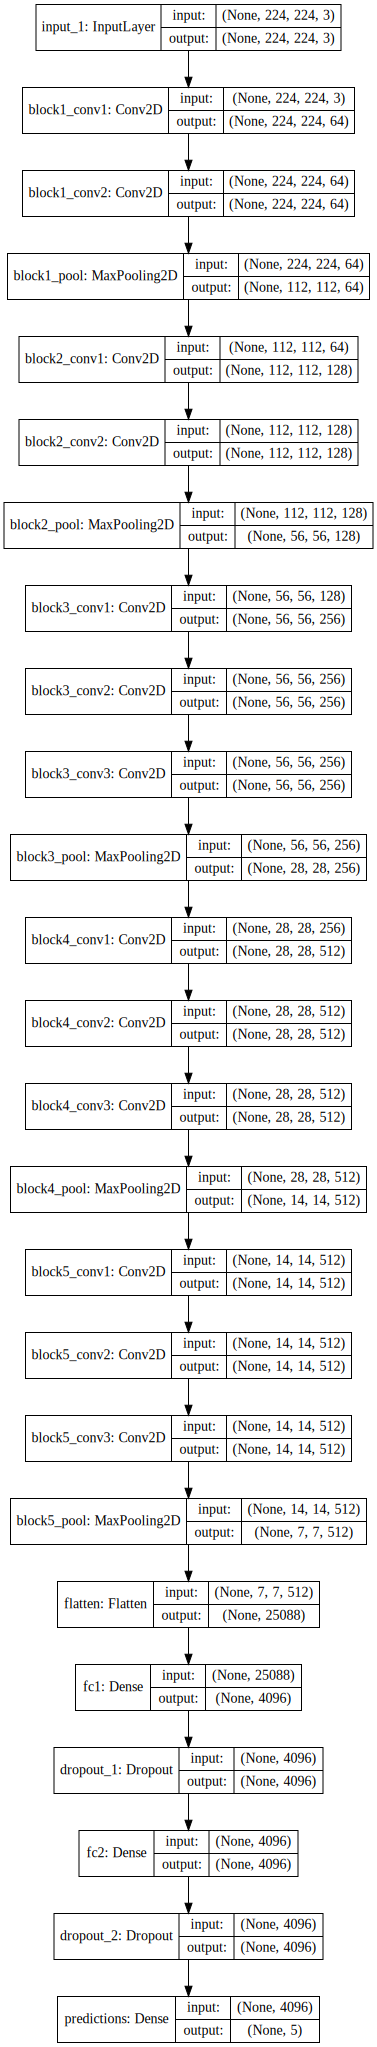

In [7]:
modelSVG_w_drop=SVG(model_to_dot(eunis_classifier_w_dropout,show_shapes=True).create(prog='dot', format='svg'))
display(modelSVG_w_drop)

In [8]:
plot_model(eunis_classifier_w_dropout,
           to_file='eunis_photo_classifier_w_drop.png',
           show_shapes=True,
           show_layer_names=True,
           rankdir='TB'
)

In [17]:
history_w_drop = eunis_classifier_w_dropout.fit_generator(train_generator, 
                                         steps_per_epoch=457,
                                         epochs=500,
                                         validation_data=validation_generator,
                                         validation_steps = 197,
                                         callbacks=[tensorboard, best_checkpoint, earlystop, reducer]
                                        )

Epoch 1/500
457/457 [==============================] - 82s 179ms/step - loss: 1.8745 - acc: 0.2691 - val_loss: 1.5113 - val_acc: 0.2487

Epoch 00001: val_acc improved from -inf to 0.24873, saving model to ./weights/unenhanced_images.h5
Epoch 2/500
457/457 [==============================] - 78s 171ms/step - loss: 1.6147 - acc: 0.2473 - val_loss: 1.5600 - val_acc: 0.2487

Epoch 00002: val_acc did not improve from 0.24873
Epoch 3/500
457/457 [==============================] - 79s 172ms/step - loss: 1.5545 - acc: 0.2691 - val_loss: 1.5757 - val_acc: 0.2487

Epoch 00003: val_acc did not improve from 0.24873
Epoch 4/500
457/457 [==============================] - 79s 172ms/step - loss: 1.5005 - acc: 0.2867 - val_loss: 1.5208 - val_acc: 0.2487

Epoch 00004: val_acc did not improve from 0.24873

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/500
457/457 [==============================] - 79s 173ms/step - loss: 1.4527 - acc: 0.2954 - val_loss: 1.3989 - va

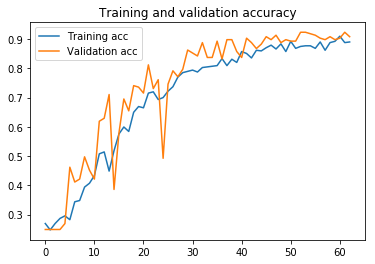

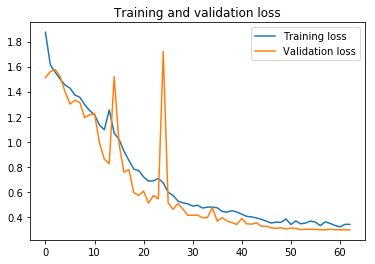

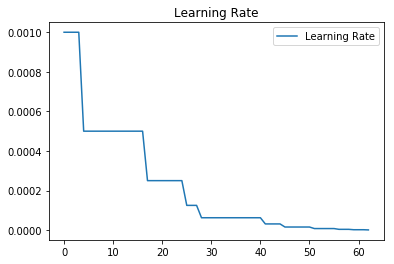

In [18]:
drop_acc = history_w_drop.history['acc']
drop_val_acc = history_w_drop.history['val_acc']
drop_loss = history_w_drop.history['loss']
drop_val_loss = history_w_drop.history['val_loss']
drop_lr = history_w_drop.history['lr']
 
drop_epochs = range(len(drop_acc))
 
plt.plot(drop_epochs, drop_acc, label='Training acc')
plt.plot(drop_epochs, drop_val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('train_val_acc_unenhanced.jpg')

plt.figure()
 
plt.plot(drop_epochs, drop_loss, label='Training loss')
plt.plot(drop_epochs, drop_val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('train_val_loss_unenhanced.jpg')
plt.show()

plt.figure()
 
plt.plot(drop_epochs, drop_lr, label='Learning Rate')
plt.title('Learning Rate')
plt.legend()
plt.savefig('learning_rate_unenhanced.jpg')
plt.show()

In [19]:
eunis_classifier_w_dropout.save_weights('./weights/unenhanced_full_training.h5')

In [22]:
createTestDirectory(pd.read_csv('/media/newdrive/20180501/ProcessedImages/unknown2-targets.csv').set_index('filename'), '/media/newdrive/20180501/ProcessedImages/')

'/media/newdrive/20180501/ProcessedImages/test'

In [23]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        '/media/newdrive/20180501/ProcessedImages/test',
        target_size=(224, 224),
        batch_size=1,
        class_mode=None,
        shuffle=False)

Found 751 images belonging to 1 classes.


In [67]:
cnn_w_drop_preds = eunis_classifier_w_dropout.predict_generator(test_generator, 
                          steps=751, verbose=1)

751/751 [==============================] - 19s 26ms/step


In [68]:
test_data = pd.read_csv('/media/newdrive/20180501/ProcessedImages/unknown2-targets.csv').set_index('filename')


In [69]:
pd.DataFrame(cnn_w_drop_preds)

0         1         2         3         4
0    0.358916  0.372460  0.035568  0.226752  0.006304
1    0.497255  0.478180  0.010723  0.012435  0.001407
2    0.669903  0.326868  0.002194  0.000565  0.000469
3    0.625032  0.372971  0.001381  0.000307  0.000308
4    0.849859  0.147451  0.002012  0.000311  0.000367
5    0.437488  0.560338  0.001524  0.000455  0.000194
6    0.341904  0.657210  0.000586  0.000174  0.000127
7    0.291178  0.707845  0.000619  0.000223  0.000134
8    0.310965  0.687947  0.000705  0.000243  0.000140
9    0.550969  0.446501  0.001691  0.000631  0.000208
10   0.385787  0.611754  0.001362  0.000873  0.000225
11   0.508812  0.481936  0.004285  0.004483  0.000484
12   0.894525  0.104493  0.000785  0.000079  0.000118
13   0.641711  0.357099  0.000967  0.000091  0.000132
14   0.685367  0.313343  0.001071  0.000088  0.000131
15   0.555567  0.443363  0.000835  0.000097  0.000139
16   0.548915  0.449901  0.000926  0.000110  0.000149
17   0.375401  0.623603  0.000730  0.000125  0.000140
18   0.378744  0.619489  0.001339  0.000242  0.000186
19   0.972045  0.026048  0.001780  0.000067  0.000061
20   0.983767  0.013252  0.002829  0.000092  0.000060
21   0.442750  0.555639  0.001256  0.000188  0.000167
22   0.213517  0.785985  0.000283  0.000109  0.000107
23   0.262362  0.737201  0.000244  0.000089  0.000104
24   0.410123  0.589207  0.000437  0.000108  0.000125
25   0.361943  0.637397  0.000391  0.000122  0.000146
26   0.580610  0.418660  0.000537  0.000083  0.000110
27   0.612837  0.386412  0.000567  0.000078  0.000105
28   0.580138  0.419146  0.000523  0.000084  0.000110
29   0.550529  0.448687  0.000562  0.000101  0.000121
..        ...       ...       ...       ...       ...
721  0.363705  0.634813  0.000488  0.000389  0.000606
722  0.948549  0.048242  0.003025  0.000111  0.000073
723  0.280477  0.718077  0.000487  0.000454  0.000504
724  0.395026  0.603874  0.000490  0.000248  0.000363
725  0.380421  0.618369  0.000565  0.000280  0.000365
726  0.912840  0.084759  0.002043  0.000233  0.000125
727  0.189356  0.809931  0.000338  0.000226  0.000149
728  0.932793  0.064495  0.002372  0.000227  0.000113
729  0.871729  0.039265  0.040616  0.011951  0.036439
730  0.438552  0.005672  0.328138  0.113437  0.114200
731  0.426369  0.005405  0.336917  0.114732  0.116577
732  0.415658  0.005177  0.344244  0.117826  0.117095
733  0.416708  0.005464  0.340677  0.120462  0.116689
734  0.431727  0.006017  0.328219  0.118069  0.115968
735  0.418031  0.007318  0.323802  0.132161  0.118688
736  0.417678  0.007746  0.321576  0.132193  0.120806
737  0.417684  0.007497  0.323670  0.130133  0.121016
738  0.413953  0.007476  0.325739  0.130778  0.122054
739  0.413423  0.007318  0.327148  0.130318  0.121793
740  0.414755  0.007442  0.325909  0.129623  0.122270
741  0.406468  0.007672  0.328355  0.132397  0.125107
742  0.407496  0.007678  0.327782  0.132298  0.124745
743  0.328577  0.021250  0.176967  0.088359  0.384847
744  0.440638  0.043309  0.090871  0.064205  0.360978
745  0.639240  0.079424  0.051611  0.039930  0.189794
746  0.777935  0.143277  0.015987  0.013028  0.049773
747  0.807070  0.187287  0.002530  0.001119  0.001994
748  0.772177  0.220508  0.002847  0.001627  0.002840
749  0.753407  0.232989  0.004694  0.003301  0.005609
750  0.163745  0.798713  0.002458  0.031848  0.003236

[751 rows x 5 columns]

In [70]:
cnn_w_drop_preds = pd.DataFrame(cnn_w_drop_preds).set_index(test_data.index)
cnn_w_drop_preds.columns = ['A3.1-A4.1', 'A3.7-A4.7', 'A5.1', 'A5.2', 'A5.4']
#cnn_w_drop_preds['level3'] = cnn_w_drop_preds.idxmax(axis=1)
cnn_w_drop_preds.head()

A3.1-A4.1  A3.7-A4.7      A5.1      A5.2  \
filename                                                                 
105317_cam-np3_frame1347.jpg   0.358916   0.372460  0.035568  0.226752   
105317_cam-np3_frame1352.jpg   0.497255   0.478180  0.010723  0.012435   
105317_cam-np3_frame1390.jpg   0.669903   0.326868  0.002194  0.000565   
105317_cam-np3_frame1468.jpg   0.625032   0.372971  0.001381  0.000307   
105317_cam-np3_frame1473.jpg   0.849859   0.147451  0.002012  0.000311   

                                  A5.4  
filename                                
105317_cam-np3_frame1347.jpg  0.006304  
105317_cam-np3_frame1352.jpg  0.001407  
105317_cam-np3_frame1390.jpg  0.000469  
105317_cam-np3_frame1468.jpg  0.000308  
105317_cam-np3_frame1473.jpg  0.000367

In [71]:
res = pd.DataFrame(cnn_w_drop_preds.columns[np.argsort(-cnn_w_drop_preds.values, axis = 1)], index=cnn_w_drop_preds.index)
cnn_w_drop_preds['first_level3'] = res[0]
cnn_w_drop_preds['second_level3'] = res[1]
cnn_w_drop_preds

A3.1-A4.1  A3.7-A4.7      A5.1      A5.2  \
filename                                                                       
105317_cam-np3_frame1347.jpg         0.358916   0.372460  0.035568  0.226752   
105317_cam-np3_frame1352.jpg         0.497255   0.478180  0.010723  0.012435   
105317_cam-np3_frame1390.jpg         0.669903   0.326868  0.002194  0.000565   
105317_cam-np3_frame1468.jpg         0.625032   0.372971  0.001381  0.000307   
105317_cam-np3_frame1473.jpg         0.849859   0.147451  0.002012  0.000311   
105317_cam-np3_frame1510.jpg         0.437488   0.560338  0.001524  0.000455   
105317_cam-np3_frame1521.jpg         0.341904   0.657210  0.000586  0.000174   
105317_cam-np3_frame1525.jpg         0.291178   0.707845  0.000619  0.000223   
105317_cam-np3_frame1526.jpg         0.310965   0.687947  0.000705  0.000243   
105317_cam-np3_frame1538.jpg         0.550969   0.446501  0.001691  0.000631   
105317_cam-np3_frame1539.jpg         0.385787   0.611754  0.001362  0.000873   
105317_cam-np3_frame1544.jpg         0.508812   0.481936  0.004285  0.004483   
105317_cam-np3_frame1580.jpg         0.894525   0.104493  0.000785  0.000079   
105317_cam-np3_frame1610.jpg         0.641711   0.357099  0.000967  0.000091   
105317_cam-np3_frame1611.jpg         0.685367   0.313343  0.001071  0.000088   
105317_cam-np3_frame1614.jpg         0.555567   0.443363  0.000835  0.000097   
105317_cam-np3_frame1615.jpg         0.548915   0.449901  0.000926  0.000110   
105317_cam-np3_frame1619.jpg         0.375401   0.623603  0.000730  0.000125   
105317_cam-np3_frame1622.jpg         0.378744   0.619489  0.001339  0.000242   
105317_cam-np3_frame1641.jpg         0.972045   0.026048  0.001780  0.000067   
105317_cam-np3_frame1646.jpg         0.983767   0.013252  0.002829  0.000092   
105317_cam-np3_frame1686.jpg         0.442750   0.555639  0.001256  0.000188   
105317_cam-np3_frame1691.jpg         0.213517   0.785985  0.000283  0.000109   
105317_cam-np3_frame1692.jpg         0.262362   0.737201  0.000244  0.000089   
105317_cam-np3_frame1693.jpg         0.410123   0.589207  0.000437  0.000108   
105317_cam-np3_frame1695.jpg         0.361943   0.637397  0.000391  0.000122   
105317_cam-np3_frame1696.jpg         0.580610   0.418660  0.000537  0.000083   
105317_cam-np3_frame1698.jpg         0.612837   0.386412  0.000567  0.000078   
105317_cam-np3_frame1699.jpg         0.580138   0.419146  0.000523  0.000084   
105317_cam-np3_frame1701.jpg         0.550529   0.448687  0.000562  0.000101   
...                                       ...        ...       ...       ...   
132143_forcadinho-np3_frame784.jpg   0.363705   0.634813  0.000488  0.000389   
132143_forcadinho-np3_frame8.jpg     0.948549   0.048242  0.003025  0.000111   
132143_forcadinho-np3_frame808.jpg   0.280477   0.718077  0.000487  0.000454   
132143_forcadinho-np3_frame813.jpg   0.395026   0.603874  0.000490  0.000248   
132143_forcadinho-np3_frame814.jpg   0.380421   0.618369  0.000565  0.000280   
132143_forcadinho-np3_frame82.jpg    0.912840   0.084759  0.002043  0.000233   
132143_forcadinho-np3_frame825.jpg   0.189356   0.809931  0.000338  0.000226   
132143_forcadinho-np3_frame83.jpg    0.932793   0.064495  0.002372  0.000227   
132143_forcadinho-np3_frame852.jpg   0.871729   0.039265  0.040616  0.011951   
132143_forcadinho-np3_frame875.jpg   0.438552   0.005672  0.328138  0.113437   
132143_forcadinho-np3_frame877.jpg   0.426369   0.005405  0.336917  0.114732   
132143_forcadinho-np3_frame878.jpg   0.415658   0.005177  0.344244  0.117826   
132143_forcadinho-np3_frame880.jpg   0.416708   0.005464  0.340677  0.120462   
132143_forcadinho-np3_frame881.jpg   0.431727   0.006017  0.328219  0.118069   
132143_forcadinho-np3_frame896.jpg   0.418031   0.007318  0.323802  0.132161   
132143_forcadinho-np3_frame899.jpg   0.417678   0.007746  0.321576  0.132193   
132143_forcadinho-np3_frame902.jpg   0.417684   0.007497  0.323670  0.130133   
132143_forcadinho-np3_frame903.jpg  

In [72]:
cnn_w_drop_preds['first_level2'] = [e[:2] for e in cnn_w_drop_preds.first_level3.values[:]]
cnn_w_drop_preds['second_level2'] = [e[:2] for e in cnn_w_drop_preds.second_level3.values[:]]
cnn_w_drop_preds.head()

A3.1-A4.1  A3.7-A4.7      A5.1      A5.2  \
filename                                                                 
105317_cam-np3_frame1347.jpg   0.358916   0.372460  0.035568  0.226752   
105317_cam-np3_frame1352.jpg   0.497255   0.478180  0.010723  0.012435   
105317_cam-np3_frame1390.jpg   0.669903   0.326868  0.002194  0.000565   
105317_cam-np3_frame1468.jpg   0.625032   0.372971  0.001381  0.000307   
105317_cam-np3_frame1473.jpg   0.849859   0.147451  0.002012  0.000311   

                                  A5.4 first_level3 second_level3  \
filename                                                            
105317_cam-np3_frame1347.jpg  0.006304    A3.7-A4.7     A3.1-A4.1   
105317_cam-np3_frame1352.jpg  0.001407    A3.1-A4.1     A3.7-A4.7   
105317_cam-np3_frame1390.jpg  0.000469    A3.1-A4.1     A3.7-A4.7   
105317_cam-np3_frame1468.jpg  0.000308    A3.1-A4.1     A3.7-A4.7   
105317_cam-np3_frame1473.jpg  0.000367    A3.1-A4.1     A3.7-A4.7   

                             first_level2 second_level2  
filename                                                 
105317_cam-np3_frame1347.jpg           A3            A3  
105317_cam-np3_frame1352.jpg           A3            A3  
105317_cam-np3_frame1390.jpg           A3            A3  
105317_cam-np3_frame1468.jpg           A3            A3  
105317_cam-np3_frame1473.jpg           A3            A3

In [73]:
ground_truth = pd.read_csv('/media/newdrive/20180501/ProcessedImages/unknown2-targets.csv').set_index('filename')
#ground_truth.index = ground_truth.filename
ground_truth.head()


date  longitude  latitude  depth EunisCode  \
filename                                                                       
105317_cam-np3_frame1347.jpg  01/05/18   -8.81545  41.53153  17.61      A3.7   
105317_cam-np3_frame1352.jpg  01/05/18   -8.81545  41.53153  17.61      A3.7   
105317_cam-np3_frame1390.jpg  01/05/18   -8.81299  41.53317   6.06      A3.1   
105317_cam-np3_frame1468.jpg  01/05/18   -8.81573  41.53185  15.50      A4.1   
105317_cam-np3_frame1473.jpg  01/05/18   -8.81139  41.53005  18.55      A4.1   

                                                                      EunisName  \
filename                                                                          
105317_cam-np3_frame1347.jpg                                                NaN   
105317_cam-np3_frame1352.jpg                                                NaN   
105317_cam-np3_frame1390.jpg  Atlantic and Mediterranean high energy infrali...   
105317_cam-np3_frame1468.jpg  Atlantic and Mediterranean high energy circali...   
105317_cam-np3_frame1473.jpg  Atlantic and Mediterranean high energy circali...   

                             level1 level2 level3  level4  level5  level6  \
filename                                                                    
105317_cam-np3_frame1347.jpg      A     A3   A3.7     NaN     NaN     NaN   
105317_cam-np3_frame1352.jpg      A     A3   A3.7     NaN     NaN     NaN   
105317_cam-np3_frame1390.jpg      A     A3   A3.1     NaN     NaN     NaN   
105317_cam-np3_frame1468.jpg      A     A4   A4.1     NaN     NaN     NaN   
105317_cam-np3_frame1473.jpg      A     A4   A4.1     NaN     NaN     NaN   

                              species  AphiaID  
filename                                        
105317_cam-np3_frame1347.jpg      NaN      NaN  
105317_cam-np3_frame1352.jpg      NaN      NaN  
105317_cam-np3_frame1390.jpg      NaN      NaN  
105317_cam-np3_frame1468.jpg      NaN      NaN  
105317_cam-np3_frame1473.jpg      NaN      NaN

In [75]:
res_preds = pd.concat([cnn_w_drop_preds[['first_level3', 'second_level3', 'first_level2', 'second_level2']], ground_truth[['level3', 'level2']]], join='inner', axis=1)
res_preds = res_preds.replace(['A3.1', 'A4.1'], 'A3.1-A4.1').replace(['A3.7', 'A4.7'], 'A3.7-A4.7').replace(['A3','A4'], 'A3-A4')
res_preds

first_level3 second_level3 first_level2  \
filename                                                                     
105317_cam-np3_frame1347.jpg          A3.7-A4.7     A3.1-A4.1        A3-A4   
105317_cam-np3_frame1352.jpg          A3.1-A4.1     A3.7-A4.7        A3-A4   
105317_cam-np3_frame1390.jpg          A3.1-A4.1     A3.7-A4.7        A3-A4   
105317_cam-np3_frame1468.jpg          A3.1-A4.1     A3.7-A4.7        A3-A4   
105317_cam-np3_frame1473.jpg          A3.1-A4.1     A3.7-A4.7        A3-A4   
105317_cam-np3_frame1510.jpg          A3.7-A4.7     A3.1-A4.1        A3-A4   
105317_cam-np3_frame1521.jpg          A3.7-A4.7     A3.1-A4.1        A3-A4   
105317_cam-np3_frame1525.jpg          A3.7-A4.7     A3.1-A4.1        A3-A4   
105317_cam-np3_frame1526.jpg          A3.7-A4.7     A3.1-A4.1        A3-A4   
105317_cam-np3_frame1538.jpg          A3.1-A4.1     A3.7-A4.7        A3-A4   
105317_cam-np3_frame1539.jpg          A3.7-A4.7     A3.1-A4.1        A3-A4   
105317_cam-np3_frame1544.jpg          A3.1-A4.1     A3.7-A4.7        A3-A4   
105317_cam-np3_frame1580.jpg          A3.1-A4.1     A3.7-A4.7        A3-A4   
105317_cam-np3_frame1610.jpg          A3.1-A4.1     A3.7-A4.7        A3-A4   
105317_cam-np3_frame1611.jpg          A3.1-A4.1     A3.7-A4.7        A3-A4   
105317_cam-np3_frame1614.jpg          A3.1-A4.1     A3.7-A4.7        A3-A4   
105317_cam-np3_frame1615.jpg          A3.1-A4.1     A3.7-A4.7        A3-A4   
105317_cam-np3_frame1619.jpg          A3.7-A4.7     A3.1-A4.1        A3-A4   
105317_cam-np3_frame1622.jpg          A3.7-A4.7     A3.1-A4.1        A3-A4   
105317_cam-np3_frame1641.jpg          A3.1-A4.1     A3.7-A4.7        A3-A4   
105317_cam-np3_frame1646.jpg          A3.1-A4.1     A3.7-A4.7        A3-A4   
105317_cam-np3_frame1686.jpg          A3.7-A4.7     A3.1-A4.1        A3-A4   
105317_cam-np3_frame1691.jpg          A3.7-A4.7     A3.1-A4.1        A3-A4   
105317_cam-np3_frame1692.jpg          A3.7-A4.7     A3.1-A4.1        A3-A4   
105317_cam-np3_frame1693.jpg          A3.7-A4.7     A3.1-A4.1        A3-A4   
105317_cam-np3_frame1695.jpg          A3.7-A4.7     A3.1-A4.1        A3-A4   
105317_cam-np3_frame1696.jpg          A3.1-A4.1     A3.7-A4.7        A3-A4   
105317_cam-np3_frame1698.jpg          A3.1-A4.1     A3.7-A4.7        A3-A4   
105317_cam-np3_frame1699.jpg          A3.1-A4.1     A3.7-A4.7        A3-A4   
105317_cam-np3_frame1701.jpg          A3.1-A4.1     A3.7-A4.7        A3-A4   
...                                         ...           ...          ...   
132143_forcadinho-np3_frame784.jpg    A3.7-A4.7     A3.1-A4.1        A3-A4   
132143_forcadinho-np3_frame8.jpg      A3.1-A4.1     A3.7-A4.7        A3-A4   
132143_forcadinho-np3_frame808.jpg    A3.7-A4.7     A3.1-A4.1        A3-A4   
132143_forcadinho-np3_frame813.jpg    A3.7-A4.7     A3.1-A4.1        A3-A4   
132143_forcadinho-np3_frame814.jpg    A3.7-A4.7     A3.1-A4.1        A3-A4   
132143_forcadinho-np3_frame82.jpg     A3.1-A4.1     A3.7-A4.7        A3-A4   
132143_forcadinho-np3_frame825.jpg    A3.7-A4.7     A3.1-A4.1        A3-A4   
132143_forcadinho-np3_frame83.jpg     A3.1-A4.1     A3.7-A4.7        A3-A4   
132143_forcadinho-np3_frame852.jpg    A3.1-A4.1          A5.1        A3-A4   
132143_forcadinho-np3_frame875.jpg    A3.1-A4.1          A5.1        A3-A4   
132143_forcadinho-np3_frame877.jpg    A3.1-A4.1          A5.1        A3-A4   
132143_forcadinho-np3_frame878.jpg    A3.1-A4.1          A5.1        A3-A4   
132143_forcadinho-np3_frame880.jpg    A3.1-A4.1          A5.1        A3-A4   
132143_forcadinho-np3_frame881.jpg    A3.1-A4.1          A5.1        A3-A4   
132143_forcadinho-np3_frame896.jpg    A3.1-A4.1          A5.1        A3-A4   
132143_forcadinho-np3_frame899.jpg    A3.1-A4.1          A5.1        A3-A4   
132143_forcadinho-np3_frame902.jpg    A3.1-A4.1          A5.1        A3-A4   
132143_forcadinho-np3_frame903.jpg    A3.1-A4.1          A5.1        A3-A4   
132143_forcadinho-np3_frame904.jpg    A3.1-A4.1          

In [76]:
errors = np.where(res_preds.first_level3 != res_preds.level3)[0]
len(errors)

229

In [77]:
cnn_w_drop_preds.to_csv('unenhanced_preds_max_checkpoint.csv')
res_preds.to_csv('unenhanced_results_max_checkpoint.csv')

In [28]:
preds = cnnpreds['first_level3']
preds_w_drop = cnn_w_drop_preds['first_level3']

NameError: name 'cnnpreds' is not defined

In [43]:
new_preds = pd.concat([preds,preds_w_drop,ground_truth['level3']],axis=1)
new_preds.columns = ['prediction', 'prediction_w_dropout', 'target']
new_preds.head()

NameError: name 'preds' is not defined

In [105]:
new_preds.to_csv('new_preds.csv')
pd.concat([new_preds['prediction'].value_counts(),new_preds['prediction_w_dropout'].value_counts(),new_preds['target'].value_counts()], axis=1).T

A3.1  A3.7  A4.1  A4.7  A5.1  A5.2  A5.4
prediction             258    88   236    24    92    34    19
prediction_w_dropout   268    71   239    25    96    33    19
target                 378   105    30    23   125    49    41

In [106]:
def getAccuracy(colname):
    count = 0
    for i in range(0,len(new_preds)):
        if(new_preds.iloc[i][colname] == new_preds.iloc[i]['target']):
            count += 1
            
    return count/len(new_preds)*100

In [107]:
print(getAccuracy('prediction'), getAccuracy('prediction_w_dropout'))

23.56857523302264 23.7017310252996


In [74]:
test_targets['EunisName'].value_counts()

Atlantic and Mediterranean high energy infralittoral rock    56
Atlantic and Mediterranean high energy circalittoral rock    53
Kelp with cushion fauna and/or foliose red seaweeds          10
Name: EunisName, dtype: int64

In [143]:
lab_df = pd.read_csv('/home/diegues/Desktop/ProcessedImages/labeled_data.csv')
lab_df.head()

filename     timestamp  latitude  longitude   roll  \
0   104728_cam-np3_frame5.jpg  1.525172e+09  41.53283   -8.81532  -3.36   
1   104728_cam-np3_frame9.jpg  1.525172e+09  41.53283   -8.81531  -2.34   
2  104728_cam-np3_frame50.jpg  1.525172e+09  41.53277   -8.81526 -25.75   
3  104728_cam-np3_frame51.jpg  1.525172e+09  41.53277   -8.81526 -25.75   
4  104728_cam-np3_frame52.jpg  1.525172e+09  41.53277   -8.81526 -25.75   

   pitch    entropy      date  depth EunisCode  \
0 -14.12  21.934646  01/05/18  16.97      A4.1   
1 -16.76  21.932552  01/05/18  16.95      A4.1   
2 -17.73  21.933617  01/05/18  16.11      A4.1   
3 -17.73  21.934235  01/05/18  16.11      A4.1   
4 -17.73  21.909359  01/05/18  16.11      A4.1   

                                           EunisName level1 level2 level3  \
0  Atlantic and Mediterranean high energy circali...      A     A4   A4.1   
1  Atlantic and Mediterranean high energy circali...      A     A4   A4.1   
2  Atlantic and Mediterranean high energy circali...      A     A4   A4.1   
3  Atlantic and Mediterranean high energy circali...      A     A4   A4.1   
4  Atlantic and Mediterranean high energy circali...      A     A4   A4.1   

  level4 level5  level6                  species   AphiaID  
0    NaN    NaN     NaN  Mesophyllum lichenoides  145188.0  
1    NaN    NaN     NaN  Mesophyllum lichenoides  145188.0  
2    NaN    NaN     NaN  Mesophyllum lichenoides  145188.0  
3    NaN    NaN     NaN  Mesophyllum lichenoides  145188.0  
4    NaN    NaN     NaN       Echinus esculentus  124287.0

In [144]:
lab_df = lab_df[~lab_df.index.isin(data.filename)]
lab_df

filename     timestamp  latitude  longitude  \
0             104728_cam-np3_frame5.jpg  1.525172e+09  41.53283   -8.81532   
1             104728_cam-np3_frame9.jpg  1.525172e+09  41.53283   -8.81531   
2            104728_cam-np3_frame50.jpg  1.525172e+09  41.53277   -8.81526   
3            104728_cam-np3_frame51.jpg  1.525172e+09  41.53277   -8.81526   
4            104728_cam-np3_frame52.jpg  1.525172e+09  41.53277   -8.81526   
5            104728_cam-np3_frame52.jpg  1.525172e+09  41.53277   -8.81526   
6            104728_cam-np3_frame53.jpg  1.525172e+09  41.53277   -8.81526   
7            104728_cam-np3_frame53.jpg  1.525172e+09  41.53277   -8.81526   
8            104728_cam-np3_frame54.jpg  1.525172e+09  41.53277   -8.81526   
9            104728_cam-np3_frame54.jpg  1.525172e+09  41.53277   -8.81526   
10           104728_cam-np3_frame55.jpg  1.525172e+09  41.53277   -8.81526   
11           104728_cam-np3_frame56.jpg  1.525172e+09  41.53277   -8.81526   
12           104728_cam-np3_frame56.jpg  1.525172e+09  41.53277   -8.81526   
13           104728_cam-np3_frame57.jpg  1.525172e+09  41.53276   -8.81525   
14           104728_cam-np3_frame57.jpg  1.525172e+09  41.53276   -8.81525   
15           104728_cam-np3_frame58.jpg  1.525172e+09  41.53276   -8.81525   
16           104728_cam-np3_frame58.jpg  1.525172e+09  41.53276   -8.81525   
17           104728_cam-np3_frame59.jpg  1.525172e+09  41.53276   -8.81525   
18           104728_cam-np3_frame60.jpg  1.525172e+09  41.53276   -8.81525   
19           104728_cam-np3_frame61.jpg  1.525172e+09  41.53276   -8.81525   
20           104728_cam-np3_frame62.jpg  1.525172e+09  41.53276   -8.81525   
21           104728_cam-np3_frame63.jpg  1.525172e+09  41.53276   -8.81525   
22           104728_cam-np3_frame64.jpg  1.525172e+09  41.53275   -8.81525   
23           104728_cam-np3_frame65.jpg  1.525172e+09  41.53275   -8.81525   
24           104728_cam-np3_frame66.jpg  1.525172e+09  41.53275   -8.81525   
25           104728_cam-np3_frame67.jpg  1.525172e+09  41.53275   -8.81525   
26           104728_cam-np3_frame68.jpg  1.525172e+09  41.53275   -8.81525   
27           104728_cam-np3_frame69.jpg  1.525172e+09  41.53275   -8.81525   
28     132143_forcadinho-np3_frame1.jpg  1.525181e+09  41.53101   -8.80974   
29     132143_forcadinho-np3_frame2.jpg  1.525181e+09  41.53101   -8.80974   
...                                 ...           ...       ...        ...   
2139  113610_cam_survey_1_frame2859.jpg  1.525176e+09  41.53307   -8.80639   
2140  113610_cam_survey_1_frame2860.jpg  1.525176e+09  41.53307   -8.80639   
2141  113610_cam_survey_1_frame2861.jpg  1.525176e+09  41.53307   -8.80639   
2142  113610_cam_survey_1_frame2862.jpg  1.525176e+09  41.53307   -8.80639   
2143  113610_cam_survey_1_frame2866.jpg  1.525176e+09  41.53307   -8.80639   
2144  113610_cam_survey_1_frame2867.jpg  1.525176e+09  41.53307   -8.80639   
2145  113610_cam_survey_1_frame2868.jpg  1.525176e+09  41.53307   -8.80639   
2146  113610_cam_survey_1_frame2869.jpg  1.525176e+09  41.53307   -8.80639   
2147  113610_cam_survey_1_frame2870.jpg  1.525176e+09  41.53307   -8.80639   
2148  113610_cam_survey_1_frame2871.jpg  1.525176e+09  41.53307   -8.80639   
2149  113610_cam_survey_1_frame2874.jpg  1.525176e+09  41.53307   -8.80639   
2150  113610_cam_survey_1_frame2876.jpg  1.525176e+09  41.53307   -8.80639   
2151  113610_cam_survey_1_frame2878.jpg  1.525176e+09  41.53307   -8.80639   
2152  113610_cam_survey_1_frame2880.jpg  1.525176e+09  41.53307   -8.80638   
2153  113610_cam_survey_1_frame2882.jpg  1.525176e+09  41.53307   -8.80638   
2154  113610_cam_survey_1_frame2884.jpg  1.525176e+09  41.53307   -8.80638   
2155  113610_cam_survey_1_frame2886.jpg  1.525176e+09  41.53307   -8.80638   
2156  113610_cam_survey_1_frame2888.jpg  1.525176e+09  41.53307   -8.80638   
2157  113610_cam_survey_1_frame2889.jpg  1.525176e+09  41.53307   -8.80638   
2158  113610_cam_survey_1_frame2890.jpg  1.525176e+09

In [145]:
lab_dir = createTestDirectory(lab_df,folder_path)

In [146]:
preds.value_counts()

A3.1    1796
A4.1    1385
A5.1     586
A3.7     580
A5.2     159
A4.7     136
A5.4      60
Name: level3, dtype: int64

In [103]:
pd.get_dummies(preds)

A3.1  A3.7  A4.1  A4.7  A5.1  A5.2  A5.4
filename                                                                   
132143_forcadinho-np3_frame7.jpg      0     0     0     1     0     0     0
132143_forcadinho-np3_frame8.jpg      0     0     0     1     0     0     0
132143_forcadinho-np3_frame9.jpg      0     0     1     0     0     0     0
132143_forcadinho-np3_frame10.jpg     0     0     1     0     0     0     0
132143_forcadinho-np3_frame11.jpg     0     0     1     0     0     0     0
132143_forcadinho-np3_frame12.jpg     0     0     1     0     0     0     0
132143_forcadinho-np3_frame13.jpg     0     0     1     0     0     0     0
132143_forcadinho-np3_frame15.jpg     0     0     1     0     0     0     0
132143_forcadinho-np3_frame16.jpg     0     0     1     0     0     0     0
132143_forcadinho-np3_frame17.jpg     0     0     1     0     0     0     0
132143_forcadinho-np3_frame19.jpg     0     0     1     0     0     0     0
132143_forcadinho-np3_frame20.jpg     0     0     1     0     0     0     0
132143_forcadinho-np3_frame21.jpg     0     0     1     0     0     0     0
132143_forcadinho-np3_frame22.jpg     0     0     1     0     0     0     0
132143_forcadinho-np3_frame24.jpg     0     0     1     0     0     0     0
132143_forcadinho-np3_frame25.jpg     0     0     1     0     0     0     0
132143_forcadinho-np3_frame27.jpg     0     0     1     0     0     0     0
132143_forcadinho-np3_frame28.jpg     0     0     1     0     0     0     0
132143_forcadinho-np3_frame29.jpg     0     0     1     0     0     0     0
132143_forcadinho-np3_frame30.jpg     0     0     1     0     0     0     0
132143_forcadinho-np3_frame31.jpg     0     0     0     0     0     1     0
132143_forcadinho-np3_frame33.jpg     0     0     1     0     0     0     0
132143_forcadinho-np3_frame34.jpg     0     0     1     0     0     0     0
132143_forcadinho-np3_frame35.jpg     0     0     1     0     0     0     0
132143_forcadinho-np3_frame36.jpg     0     0     1     0     0     0     0
132143_forcadinho-np3_frame37.jpg     0     0     1     0     0     0     0
132143_forcadinho-np3_frame60.jpg     0     0     1     0     0     0     0
132143_forcadinho-np3_frame61.jpg     0     0     1     0     0     0     0
132143_forcadinho-np3_frame62.jpg     0     0     1     0     0     0     0
132143_forcadinho-np3_frame63.jpg     0     0     1     0     0     0     0
...                                 ...   ...   ...   ...   ...   ...   ...
113610_cam_survey_1_frame2941.jpg     0     0     0     1     0     0     0
113610_cam_survey_1_frame2942.jpg     0     0     0     1     0     0     0
113610_cam_survey_1_frame2943.jpg     0     0     0     1     0     0     0
113610_cam_survey_1_frame2944.jpg     0     0     0     1     0     0     0
113610_cam_survey_1_frame2946.jpg     0     0     0     1     0     0     0
113610_cam_survey_1_frame2947.jpg     0     0     0     1     0     0     0
113610_cam_survey_1_frame2948.jpg     0     0     1     0     0     0     0
113610_cam_survey_1_frame2949.jpg     0     0     0     1     0     0     0
113610_cam_survey_1_frame2950.jpg     0     0     0     1     0     0     0
113610_cam_survey_1_frame2951.jpg     0     0     1     0     0     0     0
113610_cam_survey_1_frame2952.jpg     0     0     1     0     0     0     0
113610_cam_survey_1_frame2953.jpg     0     0     1     0     0     0     0
113610_cam_survey_1_frame2954.jpg     0     0     1     0     0     0     0
113610_cam_survey_1_frame2955.jpg     0     0     1     0     0     0     0
113610_cam_survey_1_frame2956.jpg     0     0     1     0     0     0     0
113610_cam_survey_1_frame2957.jpg     0     0     1     0     0     0     0
113610_cam_survey_1_frame2958.jpg     0     0     1     0     0     0     0
113610_cam_survey_1_frame2959.jpg     0     0     1     0     0     0     0
113610_cam_survey_1_frame2961.jpg     0     0     1     0     0     0     0
113610_cam_survey_1_frame2962.jpg     0     0     1     0     0     0     0
113610_

In [155]:
a31 = preds[preds == 'A3.1']
a41 = preds[preds == 'A4.1']
a51 = preds[preds == 'A5.1']
a37 = preds[preds == 'A3.7']
a52 = preds[preds == 'A5.2']
a47 = preds[preds == 'A4.7']
a54 = preds[preds == 'A5.4']

In [ ]:
import random

test_val_df = pd.DataFrame(columns=['filename', 'level3'])
used_a31 = []
used_a41 = []
used_a51 = []
used_a37 = []
used_a52 = []
used_a47 = []
used_a54 = []
for i in range(0,1000):
    index = len(test_val_df)
    print(index, i,)
    if i%7 == 0:
        if len(used_a31) == len(a31):
            continue
        rand = random.randint(0, len(a31) - 1)
        while rand in used_a31:
            rand = random.randint(0, len(a31) - 1)
        test_val_df.loc[index] = [a31.iloc[[rand]].index[0],a31.iloc[[rand]][0]]
            
    
    if i%7 == 1:
        if len(used_a41) == len(a41):
            continue
        rand = random.randint(0, len(a41) - 1)
        while rand in used_a41:
            rand = random.randint(0, len(a41) - 1)
        test_val_df.loc[index] = [a41.iloc[[rand]].index[0],a41.iloc[[rand]][0]]
        
    if i%7 == 2:
        if len(used_a51) == len(a51):
            continue
        rand = random.randint(0, len(a51) - 1)
        while rand in used_a51:
            rand = random.randint(0, len(a51) - 1)
        test_val_df.loc[index] = [a51.iloc[[rand]].index[0],a51.iloc[[rand]][0]]
        
    if i%7 == 3:
        if len(used_a37) == len(a37):
            continue
        rand = random.randint(0, len(a37) - 1)
        while rand in used_a37:
            rand = random.randint(0, len(a37) - 1)
        test_val_df.loc[index] = [a37.iloc[[rand]].index[0],a37.iloc[[rand]][0]]
    
    if i%7 == 4:
        if len(used_a52) == len(a52):
            continue
        rand = random.randint(0, len(a52) - 1)
        while rand in used_a52:
            rand = random.randint(0, len(a52) - 1)
        test_val_df.loc[index] = [a52.iloc[[rand]].index[0],a52.iloc[[rand]][0]]
        
    if i%7 == 5:
        if len(used_a47) == len(a47):
            continue
        rand = random.randint(0, len(a47) - 1)
        while rand in used_a47:
            rand = random.randint(0, len(a47) - 1)
        test_val_df.loc[index] = [a47.iloc[[rand]].index[0],a47.iloc[[rand]][0]]
        
    if i%7 == 6:
        if len(used_a54) == len(a54):
            continue
        rand = random.randint(0, len(a54) - 1)
        while rand in used_a54:
            rand = random.randint(0, len(a54) - 1)
        test_val_df.loc[index] = [a54.iloc[[rand]].index[0],a54.iloc[[rand]][0]]
    

In [176]:
test_val_df.head()


filename level3
0  132143_forcadinho-np3_frame3300.jpg   A3.1
1  132143_forcadinho-np3_frame3830.jpg   A4.1
2  132143_forcadinho-np3_frame1822.jpg   A5.1
3  125355_forcadinho-np3_frame1559.jpg   A3.7
4    113610_cam_survey_1_frame2648.jpg   A5.2

In [ ]:
createTestDirectory(test_val_df,folder_path)

In [ ]:
test_val_df

In [ ]:
unknown2 = pd.DataFrame(columns=new_test_data.columns)
for name in test_val_df:
    unknown2.loc[len(unknown2)] = new_test_data.loc[name]
    print(name)
unknown2

In [210]:
unknown2.index = test_val_df

In [211]:
unknown2

timestamp  latitude  longitude   roll  \
132143_forcadinho-np3_frame3300.jpg  1.525184e+09  41.53329   -8.81016  -0.62   
132143_forcadinho-np3_frame3830.jpg  1.525184e+09  41.53266   -8.81176   0.43   
132143_forcadinho-np3_frame1822.jpg  1.525183e+09  41.53376   -8.80811  -3.96   
125355_forcadinho-np3_frame1559.jpg  1.525180e+09  41.53163   -8.81047 -10.73   
113610_cam_survey_1_frame2648.jpg    1.525176e+09  41.53337   -8.80586 -23.16   
132143_forcadinho-np3_frame135.jpg   1.525181e+09  41.53095   -8.81010 -13.58   
125355_forcadinho-np3_frame54.jpg    1.525179e+09  41.53089   -8.81248   1.02   
132143_forcadinho-np3_frame4230.jpg  1.525184e+09  41.53228   -8.81264  -2.92   
132143_forcadinho-np3_frame3975.jpg  1.525184e+09  41.53238   -8.81239  -2.28   
113610_cam_survey_1_frame511.jpg     1.525175e+09  41.53317   -8.81299   0.84   
105317_cam-np3_frame1686.jpg         1.525173e+09  41.53185   -8.81573 -11.69   
125355_forcadinho-np3_frame454.jpg   1.525180e+09  41.53005   -8.81139   5.84   
132143_forcadinho-np3_frame121.jpg   1.525181e+09  41.53096   -8.81008 -30.91   
105317_cam-np3_frame1877.jpg         1.525173e+09  41.53205   -8.81591  -0.34   
132143_forcadinho-np3_frame1518.jpg  1.525183e+09  41.53323   -8.80923   1.17   
132143_forcadinho-np3_frame3864.jpg  1.525184e+09  41.53257   -8.81190  -2.06   
113610_cam_survey_1_frame626.jpg     1.525175e+09  41.53318   -8.81224   0.84   
125355_forcadinho-np3_frame1599.jpg  1.525180e+09  41.53165   -8.81047  -0.44   
113610_cam_survey_1_frame1118.jpg    1.525175e+09  41.53324   -8.81057  -1.31   
113610_cam_survey_1_frame1623.jpg    1.525176e+09  41.53328   -8.80872  -1.11   
113610_cam_survey_1_frame1089.jpg    1.525175e+09  41.53323   -8.81085   1.79   
132143_forcadinho-np3_frame2113.jpg  1.525183e+09  41.53407   -8.80766  -1.28   
132143_forcadinho-np3_frame2020.jpg  1.525183e+09  41.53401   -8.80770  -2.26   
132143_forcadinho-np3_frame3502.jpg  1.525184e+09  41.53288   -8.81114  -2.22   
105317_cam-np3_frame1347.jpg         1.525173e+09  41.53153   -8.81545  -2.73   
113610_cam_survey_1_frame1144.jpg    1.525175e+09  41.53323   -8.81057   0.70   
113610_cam_survey_1_frame1532.jpg    1.525176e+09  41.53326   -8.80970   0.82   
105317_cam-np3_frame1768.jpg         1.525173e+09  41.53197   -8.81590  -5.65   
132143_forcadinho-np3_frame4234.jpg  1.525184e+09  41.53228   -8.81264  -2.92   
113610_cam_survey_1_frame2955.jpg    1.525176e+09  41.53304   -8.80644   1.08   
...                                           ...       ...        ...    ...   
113610_cam_survey_1_frame2949.jpg    1.525176e+09  41.53304   -8.80644   0.53   
132143_forcadinho-np3_frame4135.jpg  1.525184e+09  41.53233   -8.81254  -2.13   
132143_forcadinho-np3_frame825.jpg   1.525181e+09  41.53043   -8.81204  -1.23   
132143_forcadinho-np3_frame3695.jpg  1.525184e+09  41.53272   -8.81158  -2.10   
132143_forcadinho-np3_frame4079.jpg  1.525184e+09  41.53236   -8.81244  -1.44   
113610_cam_survey_1_frame864.jpg     1.525175e+09  41.53321   -8.81122  -0.26   
132143_forcadinho-np3_frame2913.jpg  1.525184e+09  41.53366   -8.80928 -11.97   
132143_forcadinho-np3_frame1036.jpg  1.525182e+09  41.53055   -8.81171  -3.11   
125355_forcadinho-np3_frame1131.jpg  1.525180e+09  41.53078   -8.81094   0.85   
125355_forcadinho-np3_frame1655.jpg  1.525180e+09  41.53168   -8.81044 -21.84   
125355_forcadinho-np3_frame1074.jpg  1.525180e+09  41.53076   -8.81095 -15.36   
132143_forcadinho-np3_frame4091.jpg  1.525184e+09  41.53236   -8.81244   0.59   
113610_cam_survey_1_frame2855.jpg    1.525176e+09  41.53307   -8.80639  -2.21   
132143_forcadinho-np3_frame1059.jpg  1.525182e+09  41.53055   -8.81170  -0.05   
105317_cam-np3_frame1923.jpg         1.525173e+09  41.53213   -8.81600  -6.99   
132143_forcadinho-np3_frame1372.jpg  1.525183e+09  41.53303   -8.80959   0.98   
125355_forcadinho-np3_frame196.jpg   1.525179e+09  41.53061   -8.81223  -1.21   
113610_cam_survey_1_frame445.jpg     1.525175e+09  41.53316   -8.81307 

In [212]:
unknown2_folder = unknown2[['timestamp','latitude','longitude', 'roll', 'pitch', 'altitude', 'depth', 'entropy', 'date']]
unknown2_folder.to_csv(test_dir + '/unknown2/unknown2.csv')

In [213]:
unknown2_target = unknown2[['date','longitude','latitude', 'depth','EunisCode', 'EunisName', 'level1', 'level2', 'level3', 'level4', 'level5', 'level6', 'species', 'AphiaID']]
unknown2_target.to_csv(test_dir + '/unknown2/unknown2-targets.csv')

filename     timestamp  latitude  longitude  \
0    132143_forcadinho-np3_frame3300.jpg  1.525184e+09  41.53329   -8.81016   
1    132143_forcadinho-np3_frame3830.jpg  1.525184e+09  41.53266   -8.81176   
2    132143_forcadinho-np3_frame1822.jpg  1.525183e+09  41.53376   -8.80811   
3    125355_forcadinho-np3_frame1559.jpg  1.525180e+09  41.53163   -8.81047   
4      113610_cam_survey_1_frame2648.jpg  1.525176e+09  41.53337   -8.80586   
5     132143_forcadinho-np3_frame135.jpg  1.525181e+09  41.53095   -8.81010   
6      125355_forcadinho-np3_frame54.jpg  1.525179e+09  41.53089   -8.81248   
7    132143_forcadinho-np3_frame4230.jpg  1.525184e+09  41.53228   -8.81264   
8    132143_forcadinho-np3_frame3975.jpg  1.525184e+09  41.53238   -8.81239   
9       113610_cam_survey_1_frame511.jpg  1.525175e+09  41.53317   -8.81299   
10          105317_cam-np3_frame1686.jpg  1.525173e+09  41.53185   -8.81573   
11    125355_forcadinho-np3_frame454.jpg  1.525180e+09  41.53005   -8.81139   
12    132143_forcadinho-np3_frame121.jpg  1.525181e+09  41.53096   -8.81008   
13          105317_cam-np3_frame1877.jpg  1.525173e+09  41.53205   -8.81591   
14   132143_forcadinho-np3_frame1518.jpg  1.525183e+09  41.53323   -8.80923   
15   132143_forcadinho-np3_frame3864.jpg  1.525184e+09  41.53257   -8.81190   
16      113610_cam_survey_1_frame626.jpg  1.525175e+09  41.53318   -8.81224   
17   125355_forcadinho-np3_frame1599.jpg  1.525180e+09  41.53165   -8.81047   
18     113610_cam_survey_1_frame1118.jpg  1.525175e+09  41.53324   -8.81057   
19     113610_cam_survey_1_frame1623.jpg  1.525176e+09  41.53328   -8.80872   
20     113610_cam_survey_1_frame1089.jpg  1.525175e+09  41.53323   -8.81085   
21   132143_forcadinho-np3_frame2113.jpg  1.525183e+09  41.53407   -8.80766   
22   132143_forcadinho-np3_frame2020.jpg  1.525183e+09  41.53401   -8.80770   
23   132143_forcadinho-np3_frame3502.jpg  1.525184e+09  41.53288   -8.81114   
24          105317_cam-np3_frame1347.jpg  1.525173e+09  41.53153   -8.81545   
25     113610_cam_survey_1_frame1144.jpg  1.525175e+09  41.53323   -8.81057   
26     113610_cam_survey_1_frame1532.jpg  1.525176e+09  41.53326   -8.80970   
27          105317_cam-np3_frame1768.jpg  1.525173e+09  41.53197   -8.81590   
28   132143_forcadinho-np3_frame4234.jpg  1.525184e+09  41.53228   -8.81264   
29     113610_cam_survey_1_frame2955.jpg  1.525176e+09  41.53304   -8.80644   
..                                   ...           ...       ...        ...   
721    113610_cam_survey_1_frame2949.jpg  1.525176e+09  41.53304   -8.80644   
722  132143_forcadinho-np3_frame4135.jpg  1.525184e+09  41.53233   -8.81254   
723   132143_forcadinho-np3_frame825.jpg  1.525181e+09  41.53043   -8.81204   
724  132143_forcadinho-np3_frame3695.jpg  1.525184e+09  41.53272   -8.81158   
725  132143_forcadinho-np3_frame4079.jpg  1.525184e+09  41.53236   -8.81244   
726     113610_cam_survey_1_frame864.jpg  1.525175e+09  41.53321   -8.81122   
727  132143_forcadinho-np3_frame2913.jpg  1.525184e+09  41.53366   -8.80928   
728  132143_forcadinho-np3_frame1036.jpg  1.525182e+09  41.53055   -8.81171   
729  125355_forcadinho-np3_frame1131.jpg  1.525180e+09  41.53078   -8.81094   
730  125355_forcadinho-np3_frame1655.jpg  1.525180e+09  41.53168   -8.81044   
731  125355_forcadinho-np3_frame1074.jpg  1.525180e+09  41.53076   -8.81095   
732  132143_forcadinho-np3_frame4091.jpg  1.525184e+09  41.53236   -8.81244   
733    113610_cam_survey_1_frame2855.jpg  1.525176e+09  41.53307   -8.80639   
734  132143_forcadinho-np3_frame1059.jpg  1.525182e+09  41.53055   -8.81170   
735         105317_cam-np3_frame1923.jpg  1.525173e+09  41.53213   -8.81600   
736  132143_forcadinho-np3_frame1372.jpg  1.525183e+09  41.53303   -8.80959   
737   125355_forcadinho-np3_frame196.jpg  1.525179e+09  41.53061   -8.81223   
738     113610_cam_survey_1_frame445.jpg  1.525175e+09  41.53316   -8.81307   
739  132143_forcadinho-np3_frame3903.jpg  1.525184e+09  41.53243   -8.81229   
740

In [58]:
sampled_df = pd.DataFrame(columns=['level3', 'level2'])
unique_classes = pd.unique(ground_truth.level3.replace(['A3.1', 'A4.1'], 'A3.1-A4.1').replace(['A3.7', 'A4.7'], 'A3.7-A4.7'))
for c in unique_classes:
    df_c = ground_truth.replace(['A3.1', 'A4.1'], 'A3.1-A4.1').replace(['A3.7', 'A4.7'], 'A3.7-A4.7')[ground_truth.replace(['A3.1', 'A4.1'], 'A3.1-A4.1').replace(['A3.7', 'A4.7'], 'A3.7-A4.7').level3 == c][['filename', 'level3', 'level2']]
    if len(df_c) > 40:
        df_c = df_c.sample(40)
    sampled_df = pd.concat([sampled_df,df_c])
pd.unique(sampled_df.level3)

array(['A3.7-A4.7', 'A3.1-A4.1', 'A5.4', 'A5.1', 'A5.2'], dtype=object)

In [53]:
sampled_df = ground_truth.level3.replace(['A3.1', 'A4.1'], 'A3.1-A4.1').replace(['A3.7', 'A4.7'], 'A3.7-A4.7').loc[os.listdir('/home/diegues/Desktop/ProcessedImages/unknown3/')]
sampled_df.head()

filename
113610_cam_survey_1_frame626.jpg       A3.7-A4.7
132143_forcadinho-np3_frame3938.jpg         A5.2
132143_forcadinho-np3_frame2716.jpg         A5.1
132143_forcadinho-np3_frame2938.jpg    A3.7-A4.7
113610_cam_survey_1_frame2659.jpg      A3.1-A4.1
Name: level3, dtype: object

In [61]:
len(sampled_df)


200

In [85]:
new_sample_train = sampled_df.sample(n=int(len(sampled_df) * .7))
new_sample_train

filename
132143_forcadinho-np3_frame3508.jpg         A5.1
132143_forcadinho-np3_frame4096.jpg    A3.7-A4.7
132143_forcadinho-np3_frame3948.jpg    A3.1-A4.1
132143_forcadinho-np3_frame3908.jpg         A5.2
113610_cam_survey_1_frame2659.jpg      A3.1-A4.1
105317_cam-np3_frame1983.jpg           A3.7-A4.7
132143_forcadinho-np3_frame1142.jpg         A5.1
132143_forcadinho-np3_frame995.jpg          A5.2
105317_cam-np3_frame887.jpg                 A5.2
132143_forcadinho-np3_frame3946.jpg    A3.1-A4.1
132143_forcadinho-np3_frame297.jpg     A3.1-A4.1
125355_forcadinho-np3_frame1371.jpg    A3.1-A4.1
125355_forcadinho-np3_frame1683.jpg         A5.1
132143_forcadinho-np3_frame1610.jpg    A3.7-A4.7
113610_cam_survey_1_frame365.jpg       A3.7-A4.7
125355_forcadinho-np3_frame1533.jpg         A5.1
105317_cam-np3_frame848.jpg                 A5.2
113610_cam_survey_1_frame634.jpg            A5.1
132143_forcadinho-np3_frame904.jpg          A5.2
113610_cam_survey_1_frame2050.jpg      A3.1-A4.1
113610_cam_

In [86]:
new_sample_val = sampled_df.drop(new_sample_train.index)
len(new_sample_val)

60

In [89]:
i=0
for f in new_sample_train.index:
    i+=1
    copyfile(folder_path + 'test/unknown3/' + f, folder_path + 'SampledData/train/' + new_sample_train.loc[f] + '/'+ f)
for f in new_sample_val.index:
    i+=1
    copyfile(folder_path + 'test/unknown3/' + f, folder_path + 'SampledData/validation/' + new_sample_val.loc[f] + '/'+ f)
    
print(i)

200


In [88]:
new_sample_train.loc['105317_cam-np3_frame887.jpg']

'A5.2'

In [80]:
folder_path + 'test/unknown3/' + '105317_cam-np3_frame887.jpg'

'/home/diegues/Desktop/ProcessedImages/unknown3/105317_cam-np3_frame887.jpg'

In [63]:
unknown4 = ground_truth.level3.replace(['A3.1', 'A4.1'], 'A3.1-A4.1').replace(['A3.7', 'A4.7'], 'A3.7-A4.7').loc[os.listdir('/home/diegues/Desktop/ProcessedImages/test/unknown4/')]
unknown4


filename
132143_forcadinho-np3_frame3488.jpg         A5.1
113610_cam_survey_1_frame1528.jpg      A3.7-A4.7
105317_cam-np3_frame1761.jpg                A5.1
132143_forcadinho-np3_frame896.jpg          A5.2
132143_forcadinho-np3_frame337.jpg     A3.1-A4.1
113610_cam_survey_1_frame374.jpg       A3.7-A4.7
132143_forcadinho-np3_frame4229.jpg    A3.7-A4.7
105317_cam-np3_frame1789.jpg           A3.1-A4.1
113610_cam_survey_1_frame532.jpg       A3.7-A4.7
132143_forcadinho-np3_frame2349.jpg    A3.1-A4.1
125355_forcadinho-np3_frame1655.jpg    A3.1-A4.1
113610_cam_survey_1_frame515.jpg       A3.7-A4.7
132143_forcadinho-np3_frame1930.jpg         A5.1
132143_forcadinho-np3_frame3818.jpg    A3.1-A4.1
113610_cam_survey_1_frame1294.jpg      A3.1-A4.1
113610_cam_survey_1_frame1275.jpg      A3.1-A4.1
132143_forcadinho-np3_frame1439.jpg    A3.1-A4.1
132143_forcadinho-np3_frame2632.jpg    A3.1-A4.1
125355_forcadinho-np3_frame1701.jpg         A5.1
113610_cam_survey_1_frame2052.jpg      A3.1-A4.1
132143_forc

In [23]:
for f in unknown4.index:
    copyfile(folder_path + 'unknown2/' + f, folder_path + 'test/unknown4/' + f)

In [39]:
df = pd.read_csv(folder_path + "sampled_data.csv")
df = df.drop_duplicates('filename')
df = df.set_index('filename')

In [43]:
df.replace(['A3.1', 'A4.1'],'A3.1-A4.1').replace(['A3.7', 'A4.7'],'A3.7-A4.7').level3.value_counts()

A3.7-A4.7    179
A3.1-A4.1    178
A5.1         178
A5.2          85
A5.4          34
Name: level3, dtype: int64